# Introduction to the Competition

This competition aims to build a model that predicts the loan status of a user: **approve** or **reject**. The Data (`train.csv` and `test.csv`) of this competition was created using a Deep Learning Model trained on an existing [Loan Approval Prediction Dataset (Original)](https://www.kaggle.com/datasets/chilledwanker/loan-approval-prediction).

2 datasets were available for use: `train.csv` generated and provided by Kaggle and the original dataset.

The features of the dataset includes the following:
* person_age: The applicant's age.
* person_income: How much money the applicant makes per year.
* person_home_ownership: Whether the applicant owns a home or not.
* person_emp_length: How many years the applicant has been working.
* loan_intent: The reason the applicant needs the loan.
* loan_grade: A score showing how reliable the applicant is in paying back loans.
* loan_amnt: The amount of money the applicant wants to borrow.
* loan_int_rate: The interest rate charged on the loan.
* loan_percent_income: What percentage of the applicant's income will go to loan payments.
* cb_person_default_on_file: Shows if the applicant has ever failed to pay back a loan.
* cb_person_cred_hist_length: How long the applicant has had a credit history
* loan_status: Shows if the loan is approved or rejected.

The scoring criteria was **ROC AUC** score. Therefore, all model evaluations including hyperparameter tuning and model selection across all candidates will be done by **ROC AUC** score.

# Import Packages

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
random_state = 68

# Loading Data

`Dtrain` = `train.csv` data from Kaggle.

`Dtest` = `test.csv` data from Kaggle. Test ROC AUC score will be derived from this dataset.

`Dori` = original dataset of the competition.


In [2]:
# If you would like to run the code, please enter your own directory where your data resides.
path = "/kaggle/input/playground-series-s4e10" 

In [3]:
Dtrain = pd.read_csv(path + "/train.csv")
Dtrain = Dtrain.iloc[:,1:] # Drop id column.
Dtest = pd.read_csv(path + "/test.csv")
Dori = pd.read_csv(path +"/credit_risk_dataset.csv")
Dori = Dori[Dtrain.columns] # Rearrange columns.
Dtrain["Type"] = "Train"
Dtest["Type"] = "Test"
Dori["Type"] = "Original"
D = [Dtrain, Dtest, Dori]
D_name = ["Train", "Test", "Original"]
for i in range(3):
    print(D_name[i])
    display(D[i].head())
    print(D[i].shape)
    print("-----------")

Train


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,Type
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0,Train
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0,Train
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0,Train
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0,Train
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0,Train


(58645, 13)
-----------
Test


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,Type
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2,Test
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4,Test
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2,Test
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7,Test
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4,Test


(39098, 13)
-----------
Original


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,Type
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1,Original
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0,Original
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1,Original
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1,Original
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1,Original


(32581, 13)
-----------


In [4]:
def set_varType(d):
    d['person_home_ownership'] = d['person_home_ownership'].astype('category')
    d['loan_intent'] = d['loan_intent'].astype('category')
    d['cb_person_default_on_file'] = d['cb_person_default_on_file'].astype('category')
    d['Type'] = d['Type'].astype('category')
    d['loan_grade'] = pd.Categorical(d['loan_grade'], categories=['A','B','C','D','E','F','G'], ordered=True)
    return d
for i in range(3):
    D[i] = set_varType(D[i])

# EDA

In this Exploratory Data Analysis, we will try to check the following few criterias:
* Missing / Duplicate Values
* Distributions of each features: To check for any outliers or special trends.
* Comparison of distributions of `Dtrain`, `Dori`, and `Dtest`, to check whether train distributions matches the test distritbution.
* Comparison of distributions across different target values to gain some insight on each variable would be more predictive.
* The correlation of variables.

In [5]:
# Numerical, Categorical Variables, and Target Variable
num_var = ["person_age", "person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]
cat_var = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]
tar_var = ["loan_status"]

## Missing / Duplicate Values

### Duplicates

In [6]:
for i in range(3):
    print(D_name[i])
    print("Duplicates: " + str(D[i].duplicated().sum()))
    print("-----------")

Train
Duplicates: 0
-----------
Test
Duplicates: 0
-----------
Original
Duplicates: 165
-----------


In [7]:
## Duplicates Removed
D[2] = D[2][~D[2].duplicated()]
print(D_name[2])
print("Duplicates: " + str(D[2].duplicated().sum()))

Original
Duplicates: 0


### Missing Values

In [8]:
missing_vals = [D[0].isna().sum() + (D[i] == '').sum(), D[1].isna().sum() + (D[i] == '').sum(), D[2].isna().sum() + (D[i] == '').sum()]
mv_df = pd.DataFrame(missing_vals).T[:-1]
mv_df.columns = D_name
display(mv_df)

,Train,Test,Original
person_age,0.0,0.0,0.0
person_income,0.0,0.0,0.0
person_home_ownership,0.0,0.0,0.0
person_emp_length,0.0,0.0,887.0
loan_intent,0.0,0.0,0.0
loan_grade,0.0,0.0,0.0
loan_amnt,0.0,0.0,0.0
loan_int_rate,0.0,0.0,3095.0
loan_percent_income,0.0,0.0,0.0
cb_person_default_on_file,0.0,0.0,0.0


Note: `Dori` has Missing Values. These can be either dropped, or inferred from other data.

Note: `loan_status` value for the test is missing as Test Set does not contain it.

## Numerical Variables

### Basic Summary

In [9]:
for i in range(3):
    print(D_name[i])
    display(D[i][num_var].describe())
    print("-----------")

Train


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000


-----------
Test


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000
mean,27.566781,6.406046e+04,4.687068,9251.466188,10.661216,0.159573,5.830707
std,6.032761,3.795583e+04,3.868395,5576.254680,3.020220,0.091633,4.072157
min,20.000000,4.000000e+03,0.000000,700.000000,5.420000,0.000000,2.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,30.000000,7.588500e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,94.000000,1.900000e+06,42.000000,35000.000000,22.110000,0.730000,30.000000


-----------
Original


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,32416.000000,3.241600e+04,31529.00000,32416.000000,29321.000000,32416.000000,32416.000000
mean,27.747008,6.609164e+04,4.79051,9593.845632,11.017265,0.170250,5.811297
std,6.354100,6.201558e+04,4.14549,6322.730241,3.241680,0.106812,4.059030
min,20.000000,4.000000e+03,0.00000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,3.854200e+04,2.00000,5000.000000,7.900000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.00000,8000.000000,10.990000,0.150000,4.000000
75%,30.000000,7.921800e+04,7.00000,12250.000000,13.470000,0.230000,8.000000
max,144.000000,6.000000e+06,123.00000,35000.000000,23.220000,0.830000,30.000000


-----------


Note: `person_age` and `person_emp_length` variable for Train and Original Dataset seems to have outliers. Need some check.

### Strange Values Check

In [10]:
# Outliers Check - Train
print("The Strange Values: ")
display(D[0][num_var][(D[0]["person_age"]==123) | (D[0]["person_emp_length"]==123)])
print("Basic Summary of `Dtrain` without 123s: ")
display(D[0][(D[0]["person_age"]!=123) & (D[0]["person_emp_length"]!=123)].describe())

The Strange Values: 


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
41079,28,60350,123.0,25000,15.95,0.35,6
47336,123,36000,7.0,6700,10.75,0.18,4
49252,21,192000,123.0,20000,11.49,0.10,2


Basic Summary of `Dtrain` without 123s: 


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58642.000000,5.864200e+04,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000
mean,27.549333,6.404453e+04,4.696941,9217.146448,10.677770,0.159235,5.813649,0.142372
std,6.020420,3.792822e+04,3.899139,5563.380070,3.034695,0.091690,4.029261,0.349435
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,84.000000,1.900000e+06,41.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [11]:
# Outliers Check - Original
print("The Strange Values: ")
display(D[2][num_var][(D[2]["person_age"]==123) | (D[2]["person_age"]==144) | (D[2]["person_emp_length"]==123)])
print("Basic Summary of `Dori` without 123s and 144s: ")
display(D[2][(D[2]["person_age"]!=123) & (D[2]["person_age"]!=144) & (D[2]["person_emp_length"]!=123)].describe())

The Strange Values: 


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,22,59000,123.0,35000,16.02,0.59,3
81,144,250000,4.0,4800,13.57,0.02,3
183,144,200000,4.0,6000,11.86,0.03,2
210,21,192000,123.0,20000,6.54,0.10,4
575,123,80004,2.0,20400,10.25,0.25,3
747,123,78000,7.0,20000,NaN,0.26,4
32297,144,6000000,12.0,5000,12.73,0.00,25


Basic Summary of `Dori` without 123s and 144s: 


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,32409.000000,3.240900e+04,31522.000000,32409.000000,29315.000000,32409.000000,32409.000000,32409.000000
mean,27.730754,6.589428e+04,4.782850,9592.486655,11.017099,0.170248,5.811194,0.218705
std,6.210445,5.251787e+04,4.037343,6320.885127,3.241718,0.106785,4.057899,0.413374
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.090000,3.000000,0.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000,0.000000
75%,30.000000,7.920000e+04,7.000000,12250.000000,13.470000,0.230000,8.000000,0.000000
max,94.000000,2.039784e+06,41.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


Note: Since there are only 3 and 7 strange values in Train and Original Datasets respectively, and since there are no 123 nor 144 values in Test Data, decided to remove these outliers. (Since the data pool is large enough, wouldn't affect training much.)

In [12]:
D[0] = D[0][(D[0]["person_age"]!=123) & (D[0]["person_emp_length"]!=123)]
D[2] = D[2][(D[2]["person_age"]!=123) & (D[2]["person_age"]!=144) & (D[2]["person_emp_length"]!=123)]

### Visualizations

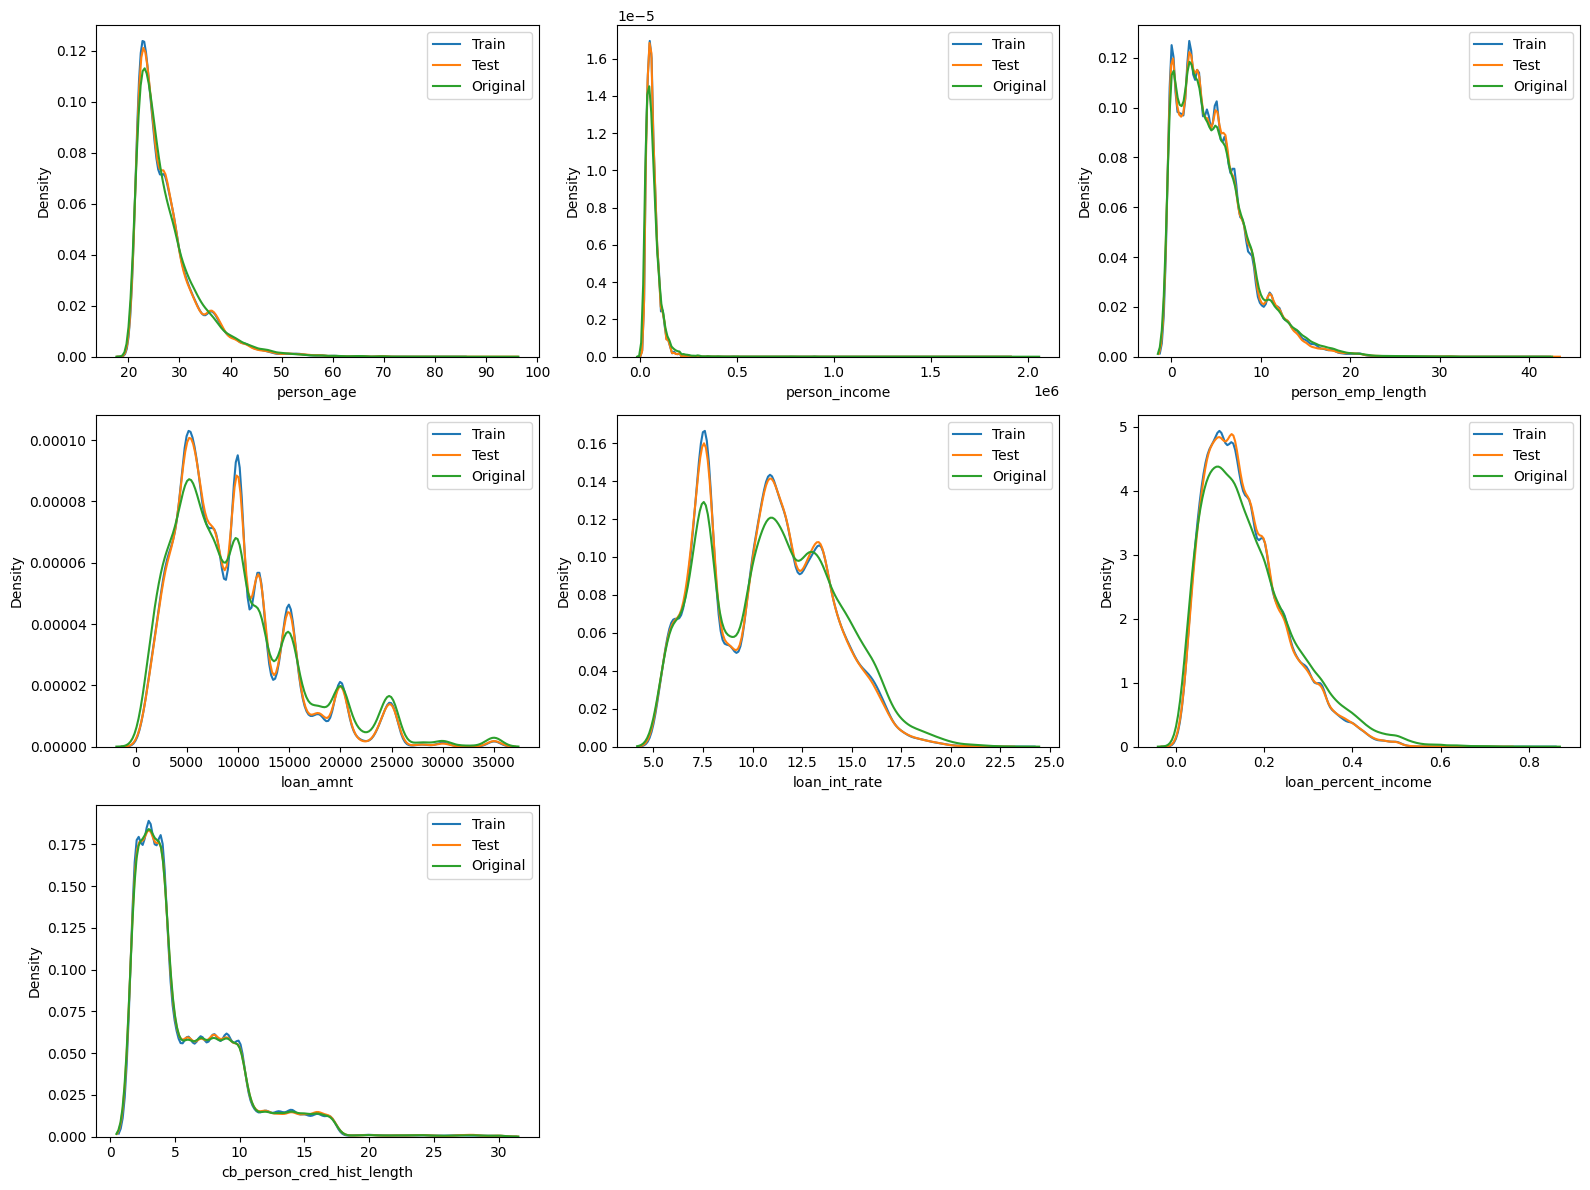

In [13]:
# Visualizations 1 - Check Differences in Distributions Among Datasets
plt.figure(figsize=(16, 12))
for i, col in enumerate(num_var):
    plt.subplot(3, 3, i+1)
    sns.kdeplot(D[0], x=col)
    sns.kdeplot(D[1], x=col)
    sns.kdeplot(D[2], x=col)
    plt.legend(labels=["Train", "Test", "Original"])
plt.tight_layout()
plt.show()

Note: Train and Test seems to share similar distributions of data for all variables. Original Dataset, however, seems to be little smoother than others. (Because the other datasets are synthetically created from the Original Dataset.) Since training set and test set should share similar distributions to get a better outcome, the use of original dataset should be carefully considered.

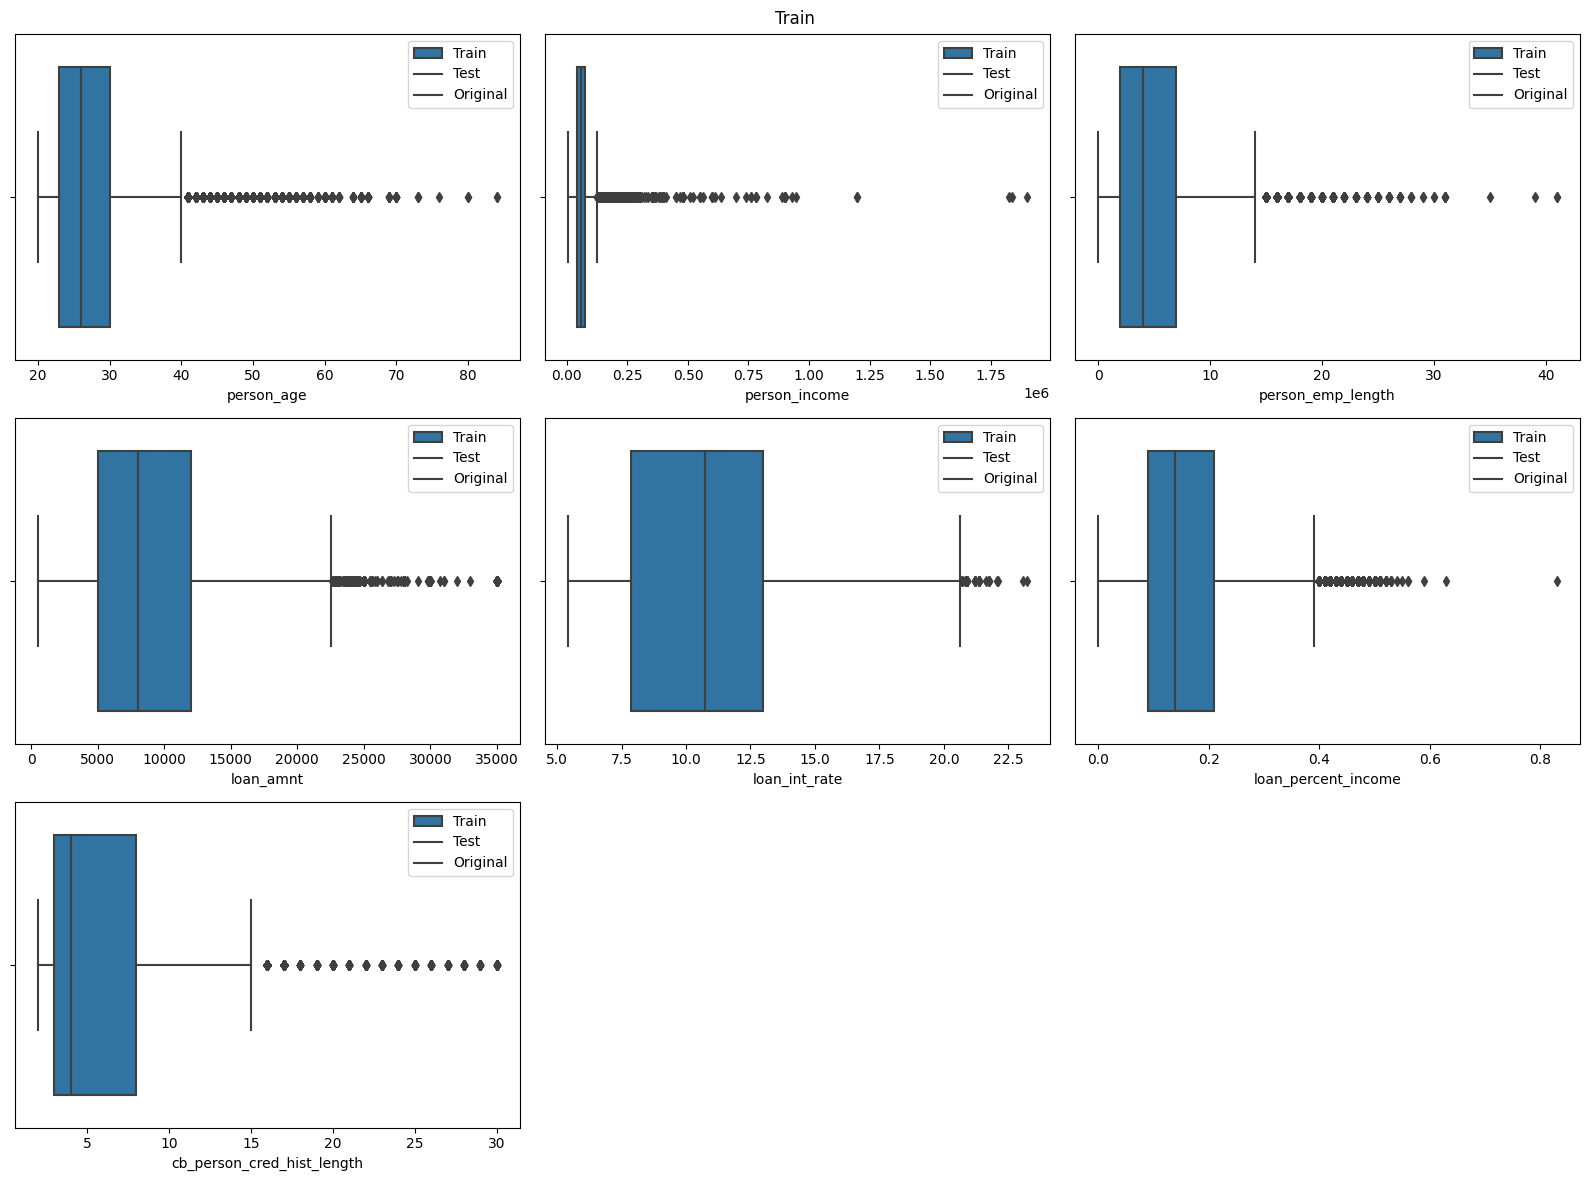

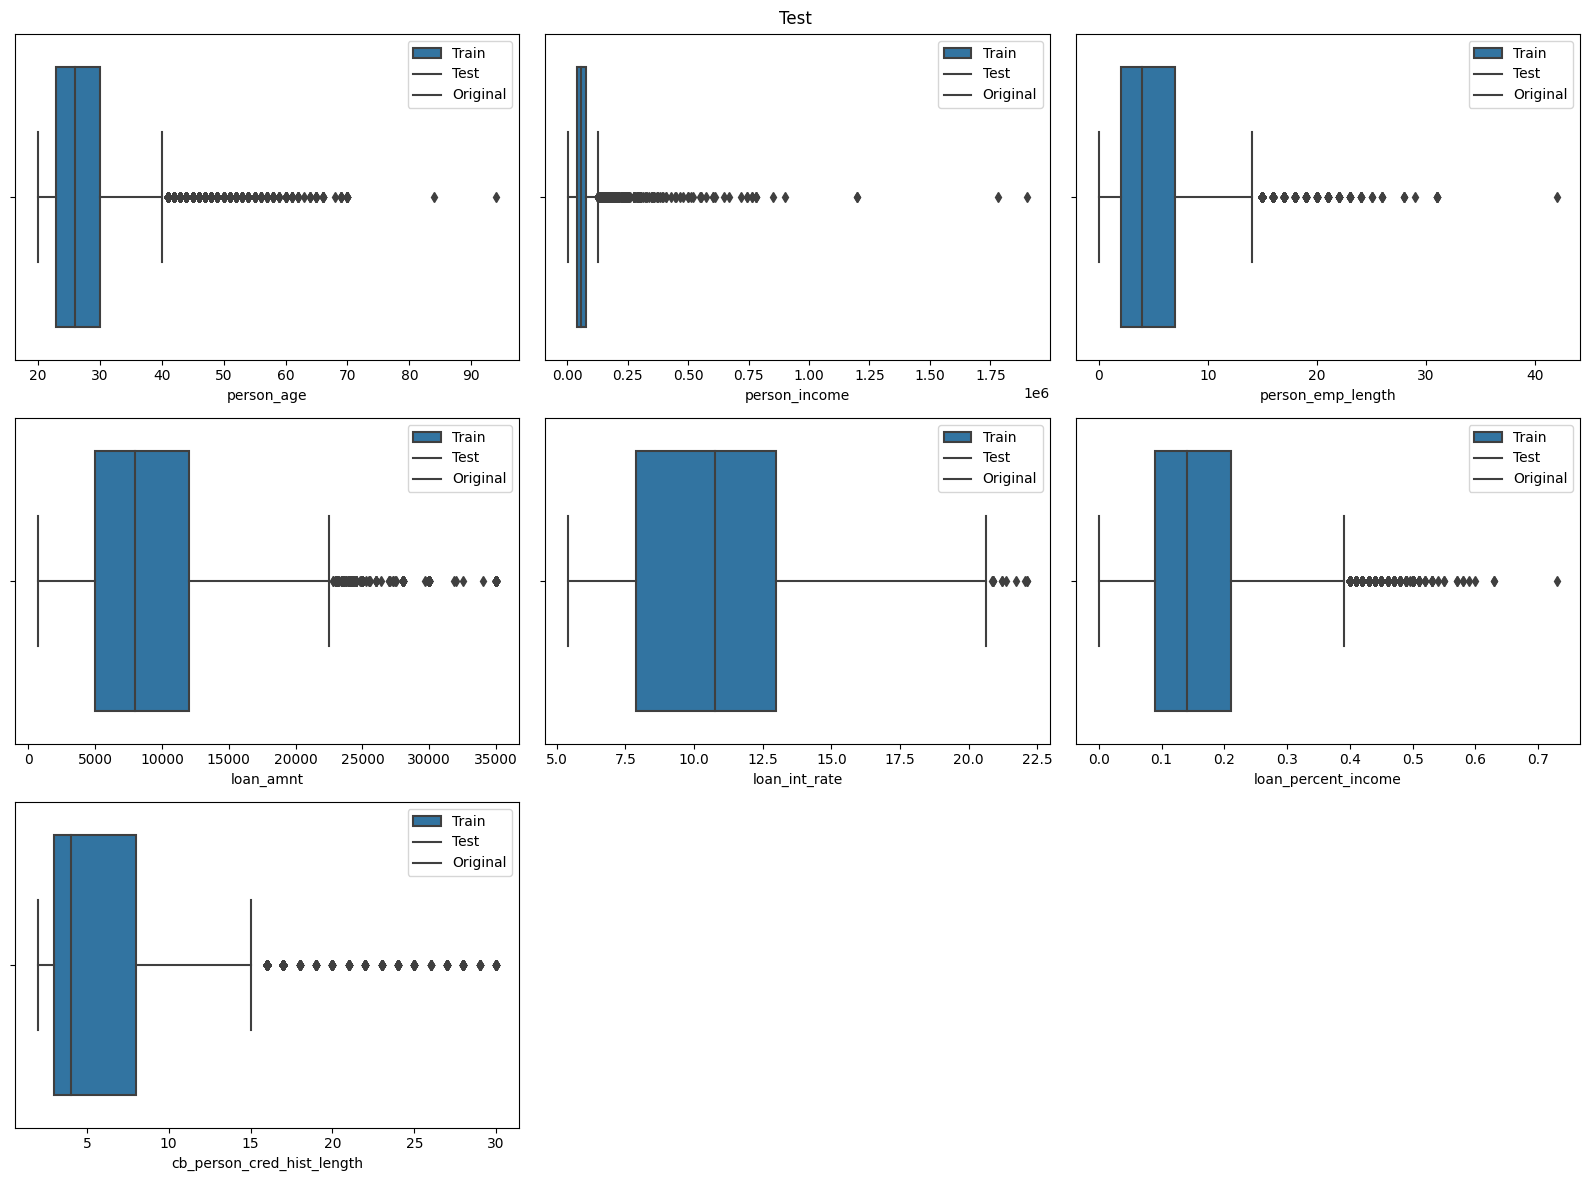

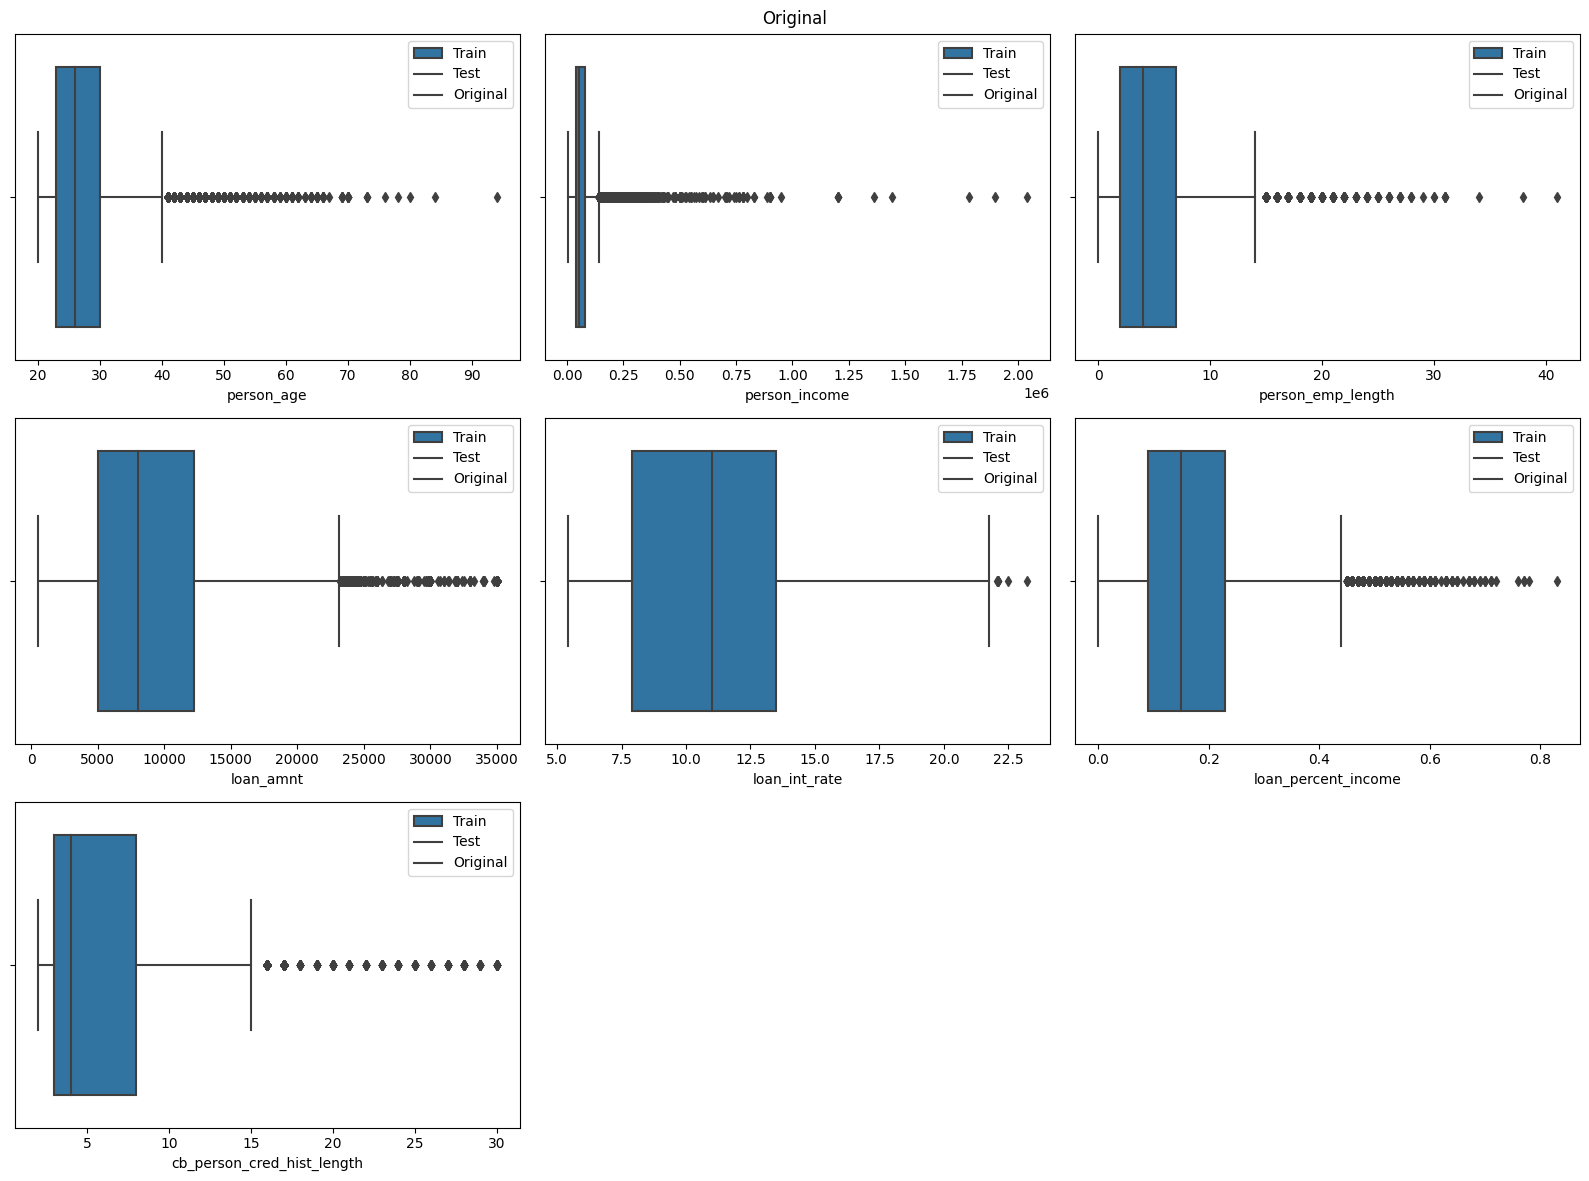

In [14]:
# Visualizations 2 - Checking Outliers
plt.figure(figsize=(16, 12))
for i, col in enumerate(num_var):
    plt.subplot(3, 3, i+1)
    sns.boxplot(D[0], x=col, orient="h")
    plt.legend(labels=["Train", "Test", "Original"])
plt.suptitle("Train")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 12))
for i, col in enumerate(num_var):
    plt.subplot(3, 3, i+1)
    sns.boxplot(D[1], x=col, orient="h")
    plt.legend(labels=["Train", "Test", "Original"])
plt.suptitle("Test")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 12))
for i, col in enumerate(num_var):
    plt.subplot(3, 3, i+1)
    sns.boxplot(D[2], x=col, orient="h")
    plt.legend(labels=["Train", "Test", "Original"])
plt.suptitle("Original")
plt.tight_layout()
plt.show()

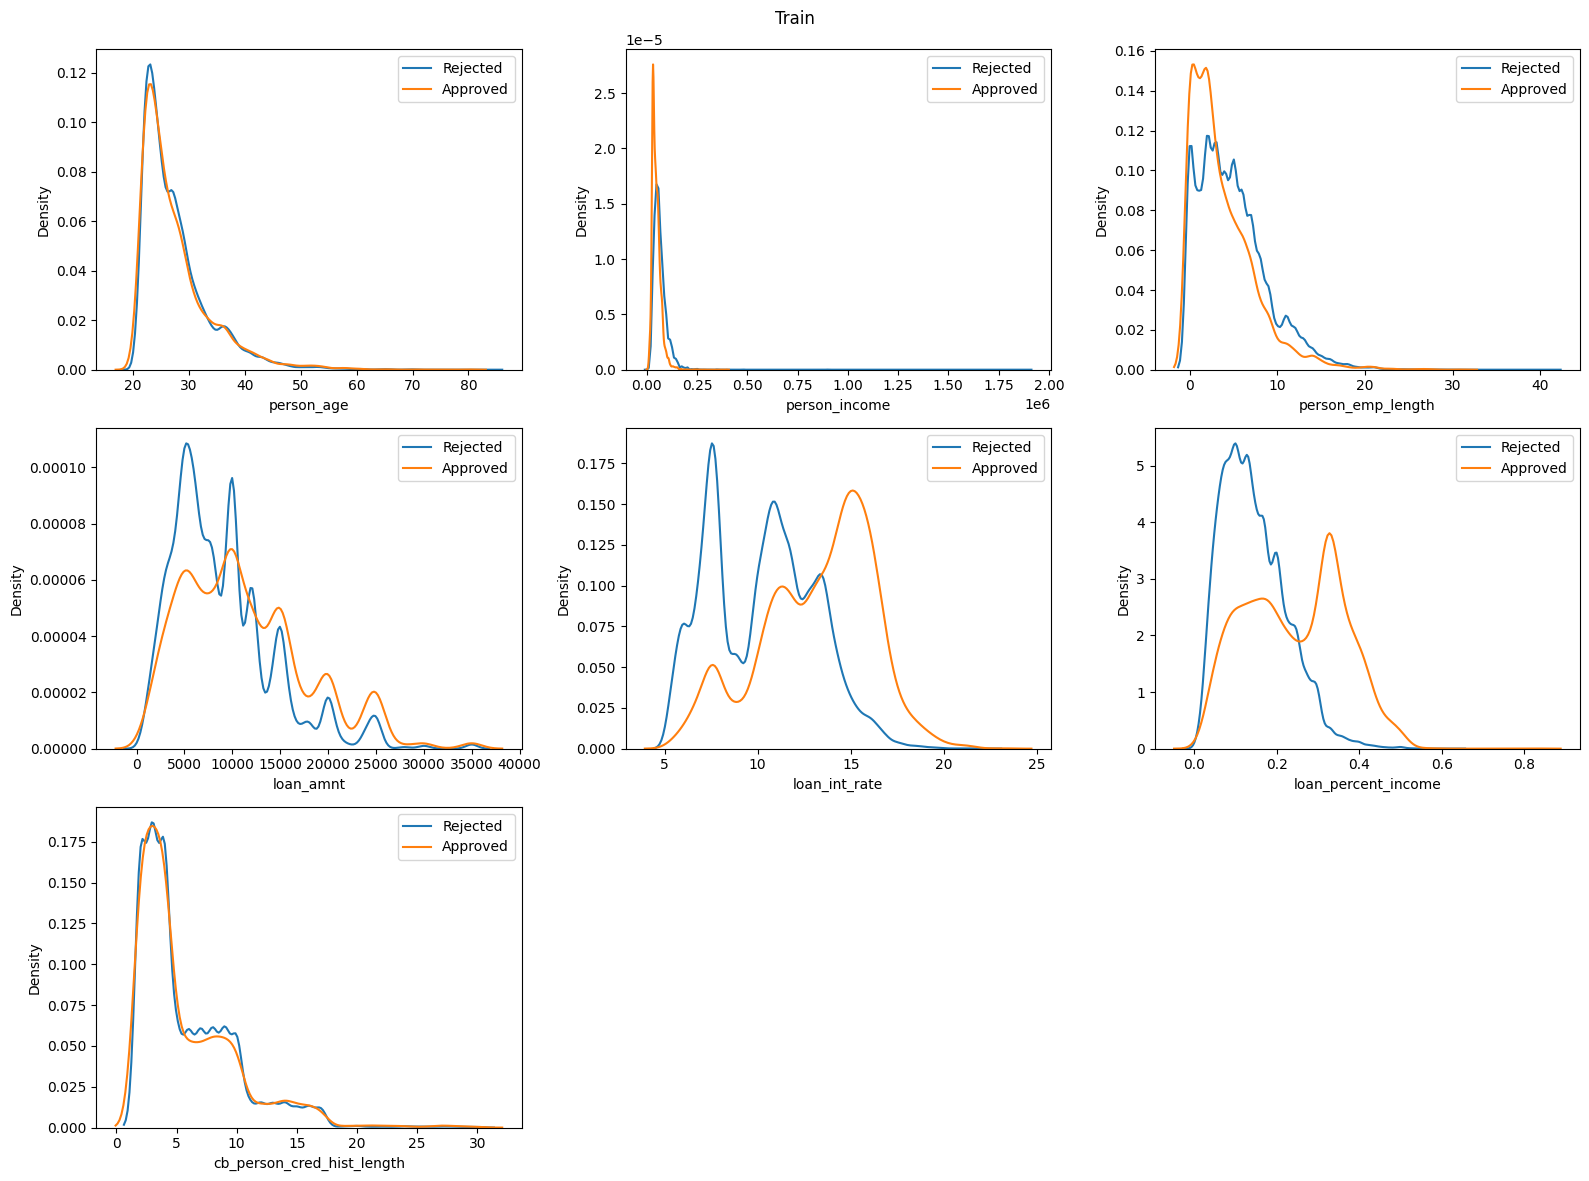

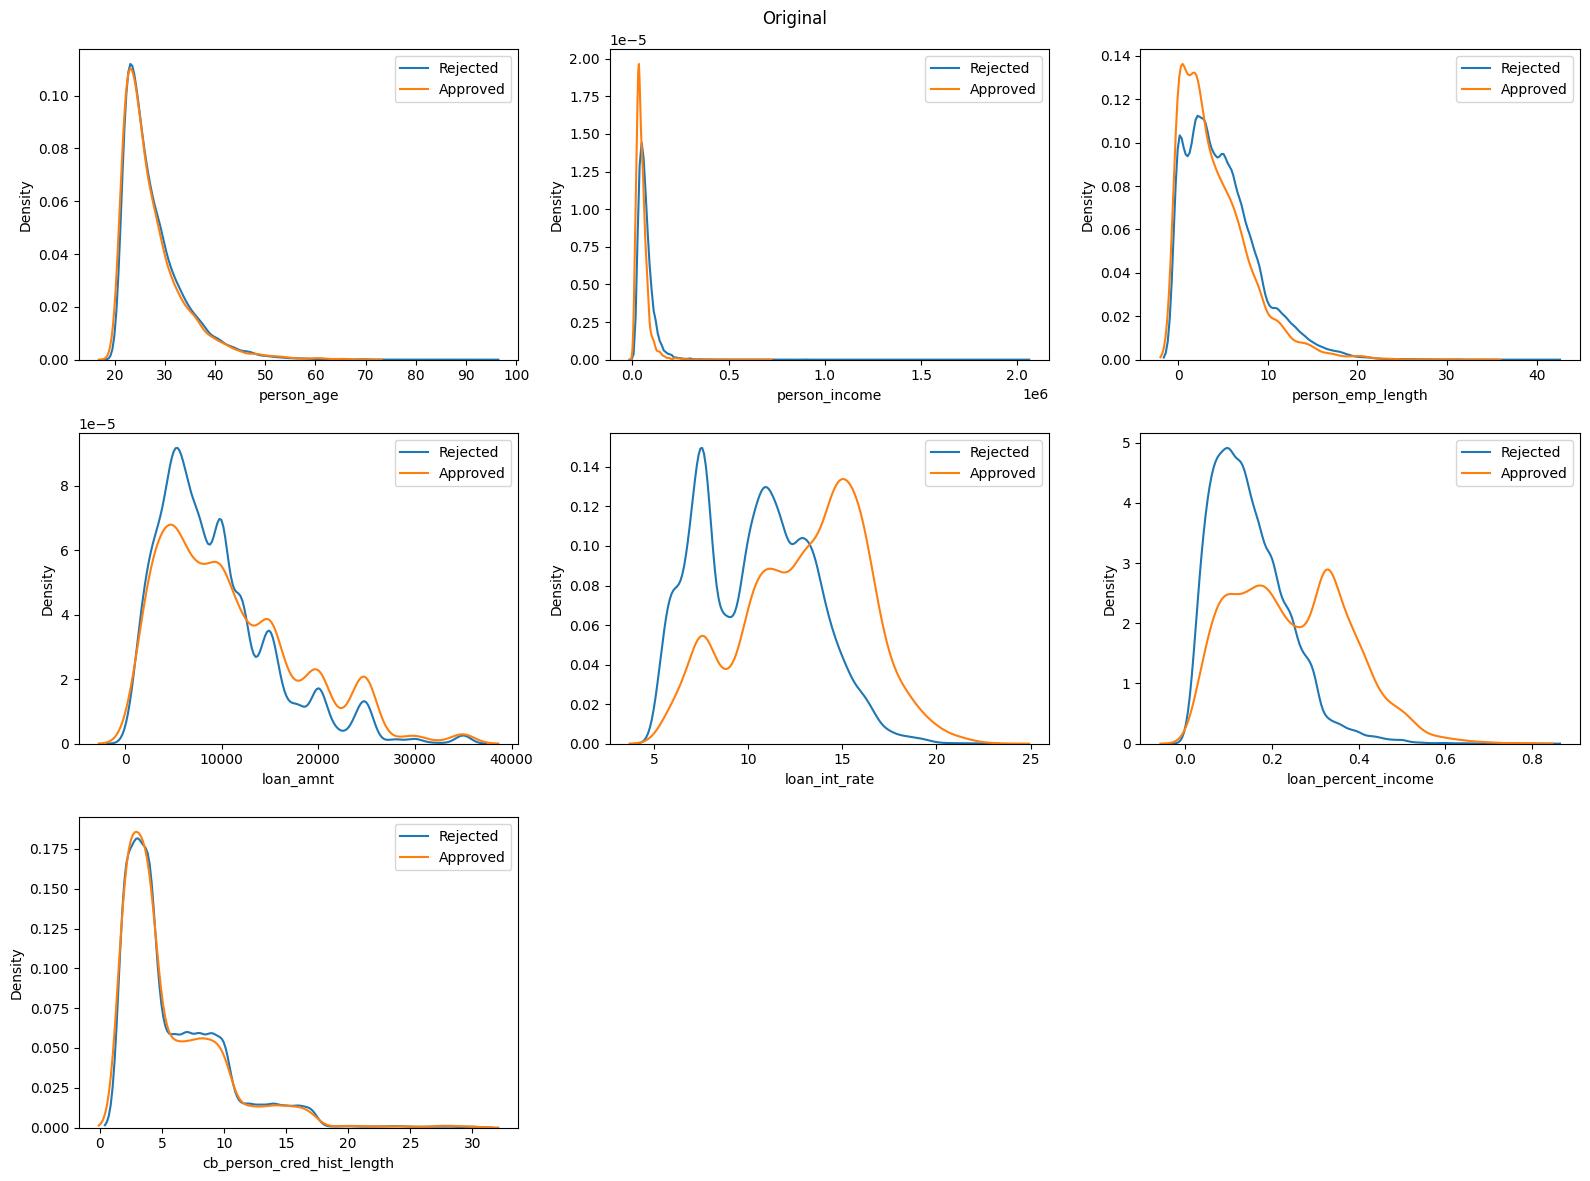

In [15]:
# Visualization 3 - Check Differences in Distribution for Target 0 and 1
plt.figure(figsize=(16, 12))
for i, col in enumerate(num_var):
    plt.subplot(3, 3, i+1)
    sns.kdeplot(D[0][D[0]["loan_status"]==0], x=col)
    sns.kdeplot(D[0][D[0]["loan_status"]==1], x=col)
    plt.legend(["Rejected", "Approved"])
plt.suptitle("Train")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 12))
for i, col in enumerate(num_var):
    plt.subplot(3, 3, i+1)
    sns.kdeplot(D[2][D[2]["loan_status"]==0], x=col)
    sns.kdeplot(D[2][D[2]["loan_status"]==1], x=col)
    plt.legend(["Rejected", "Approved"])
plt.suptitle("Original")
plt.tight_layout()
plt.show()

Note: Most differences between `target 0` and `target 1` comes from the variables `person_emp_length`, `loan_amnt`, `loan_int_rate`, and `loan_percent_income` (with large differences between distributions). `person_income` also does shows some differences, with `target 1` having higher proportion of people within a certain range of values.

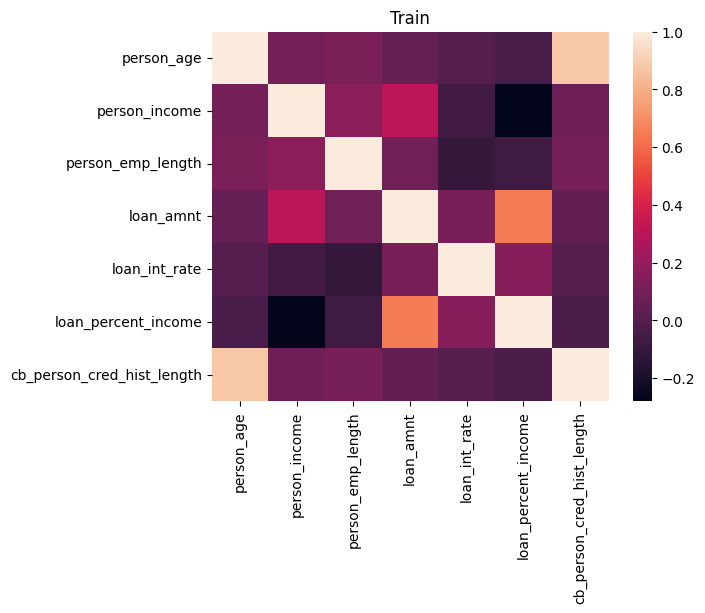

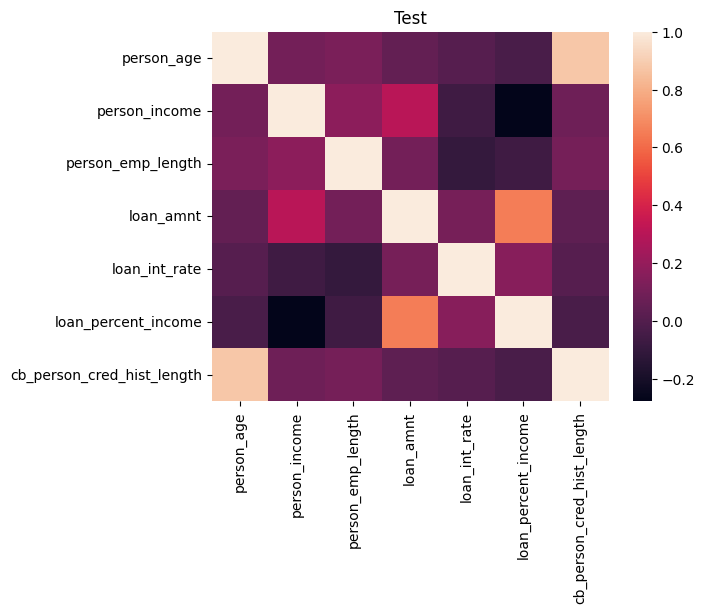

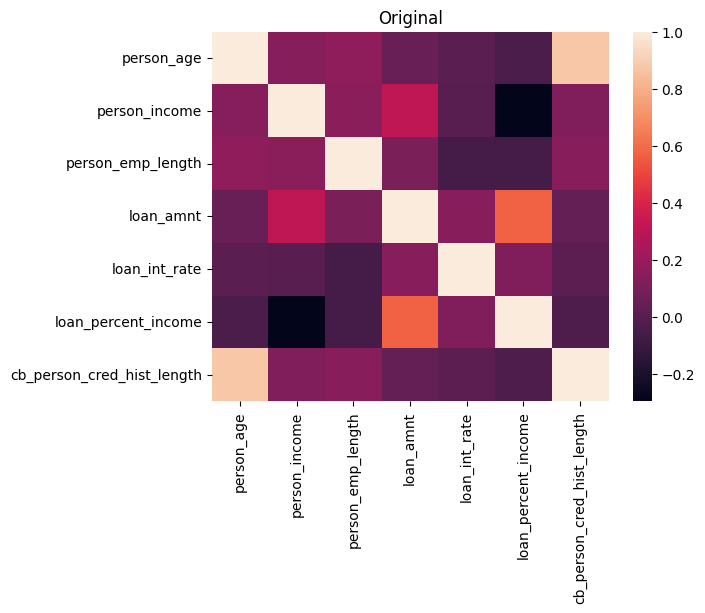

In [16]:
for i in range(3):
    sns.heatmap(D[i][num_var].corr())
    plt.title(D_name[i])
    plt.show()

## Categorical Variables

### Basic Summary

In [17]:
for i in range(3):
    print(D_name[i])
    display(D[i][cat_var].describe())
    print("-----------")

Train


,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,58642,58642,58642,58642
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,30594,12271,20984,49941


-----------
Test


,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,39098,39098,39098,39098
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,20280,8076,14005,33227


-----------
Original


,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,32409,32409,32409,32409
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,16374,6409,10702,26680


-----------


### Visualizations

<Figure size 1600x1200 with 0 Axes>

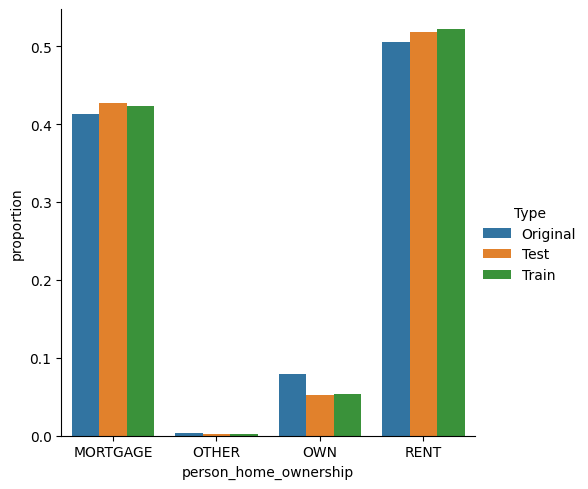

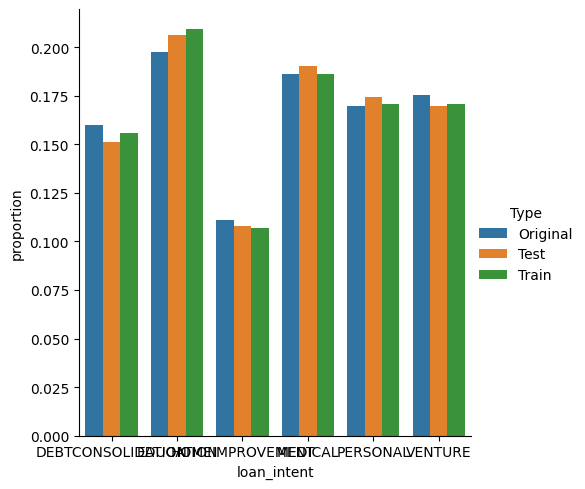

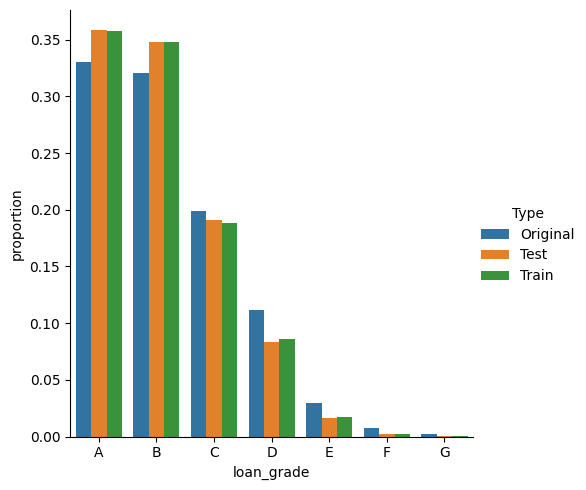

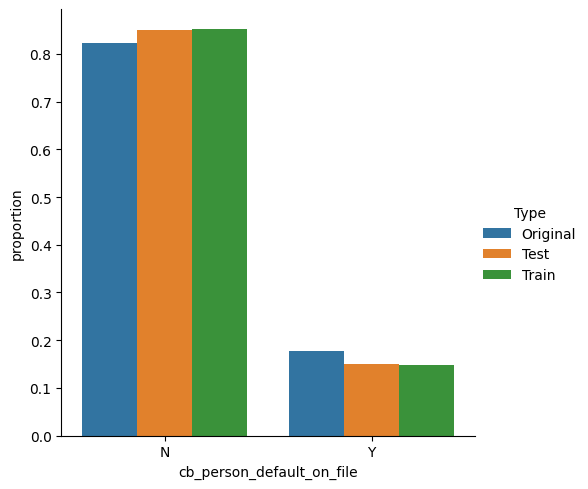

In [18]:
# Visualizations 1 - Difference in Distribution Among Datasets
plt.figure(figsize=(16, 12))
D_tmp = pd.concat(D, ignore_index = True)
for i, col in enumerate(cat_var):
    d_tmp = D_tmp.groupby("Type")[col].value_counts(normalize=True).reset_index()
    sns.catplot(d_tmp, x=col, y="proportion", hue="Type", kind="bar")
    plt.show()

Note: The distributions of the feature variable seems to follow similar trends across different datasets.

<Figure size 1600x1200 with 0 Axes>

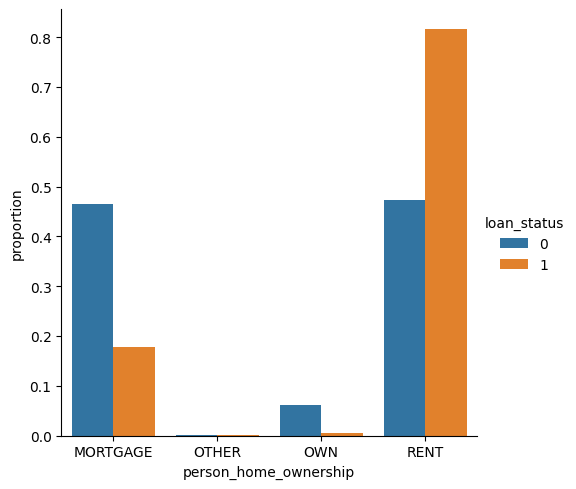

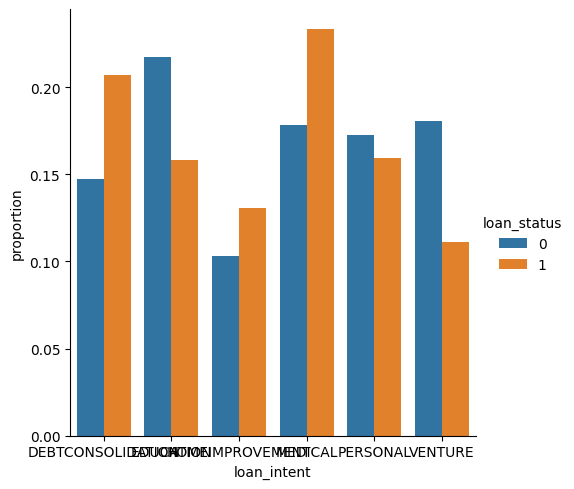

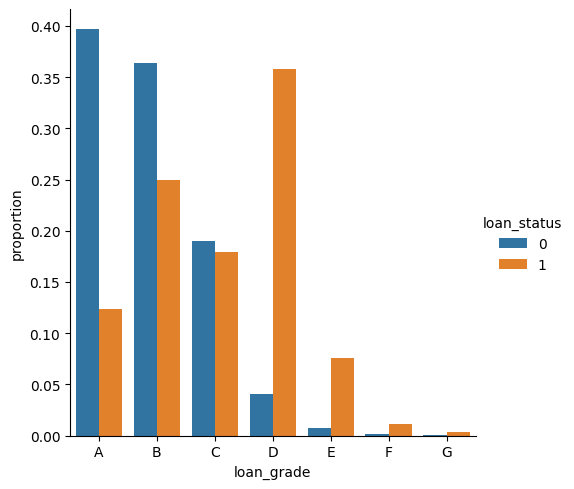

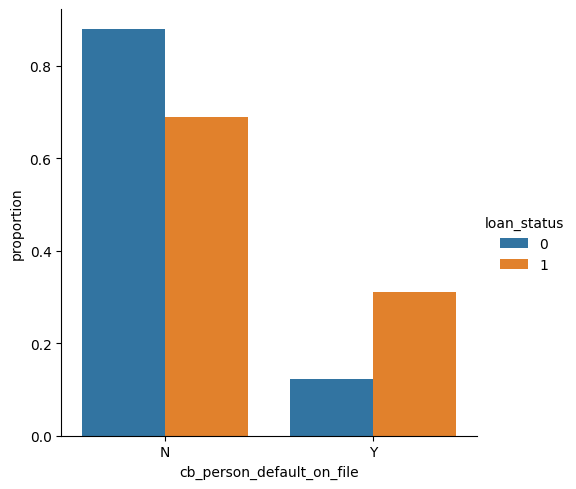

In [19]:
# Visualizations 2 - Difference in Distributions between Target Variables (Train)
plt.figure(figsize=(16, 12))
for i, col in enumerate(cat_var):
    d_tmp = D[0].groupby("loan_status")[col].value_counts(normalize=True).reset_index()
    sns.catplot(d_tmp, x=col, y="proportion", hue="loan_status", kind="bar")
    plt.show()

Note: Most categorical features, especially `loan_grade` showed high difference across target variables.

## Target Variable EDA

## Basic Count Plot

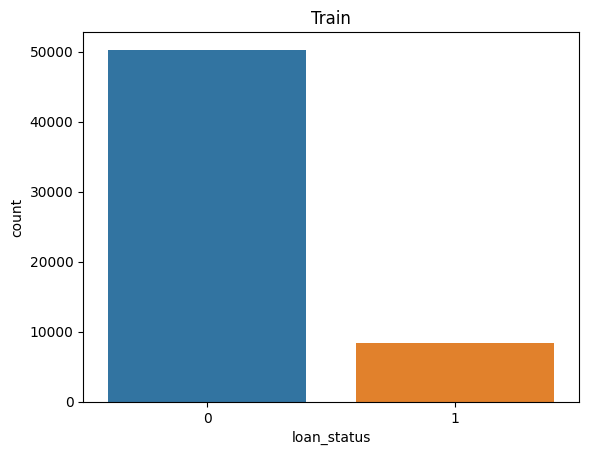

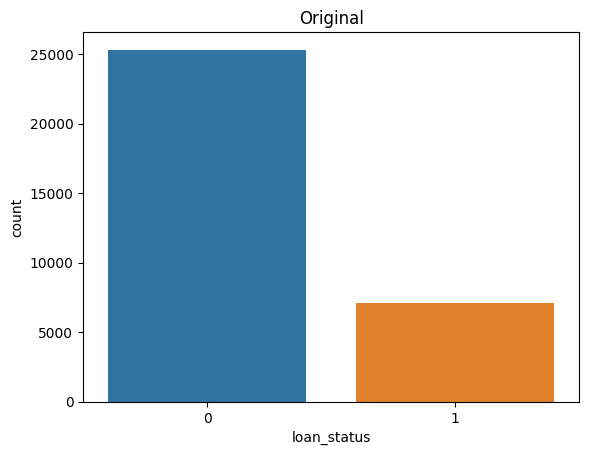

In [20]:
sns.countplot(D[0], x="loan_status")
plt.title("Train")
plt.show()

sns.countplot(D[2], x="loan_status")
plt.title("Original")
plt.show()

Note: The dataset is greatly imbalanced. This may cause the model to learn about **target 1** insufficiently, but since dataset size is quite large, this may not be a problem.

# Preprocessing Data / Feature Engineering

Note: All preprocessing and feature engineering of data, including Categorical Variable Encoding, Imputation of Missing Values, Creation of New Variable, and Normalizing Scale will be gathered up into a single function, and will be applied after cross validation split is done, to reduce contamination of CV data.

## 3 Versions: Train, Train + Original, Train + Original (Missing Values Removed)

3 versions of dataset will be created and tested:
1. Use of `Dtrain` only.
2. Use of `Dtrain` + `Dori`, with missing values imputed by another model trained on that data.
3. Use of `Dtrain` + `Dori`, with missing values completely removed.

In [21]:
Dtrain_train, Dtrain_cv, _, _ = train_test_split(D[0], D[0]['loan_status'], test_size=0.1, random_state=random_state)
Dtrain_train = Dtrain_cv.reset_index(drop=True)
Dtrain_cv = Dtrain_cv.reset_index(drop=True)

`Dtrain_cv` is created to test between different models trained. Examples in `Dtrain` was chosen only in creationg of cv dataset because `Dtest` and `Dtrain` shares similar distributions while Dori shows a little difference in distribution. 10% out of about 60,000 `Dtrain` data was randomly chosen for this dataset.

In below, `Dmerged` = Simpled merging of `Dtrain` and `Dori` and `Dmerged_rmvd` = Missing-Value-Dropped version of `Dmerged` is created. The imputed version of `Dmerged` will later be created.

In [22]:
Dmerged = pd.concat([Dtrain_train,D[2]]).reset_index(drop=True)
Dmerged["Type"] = (Dmerged["Type"] == "Train").astype("int")
Dmerged_rmvd = Dmerged[~((Dmerged.isna()["person_emp_length"]) | (Dmerged.isna()["loan_int_rate"]))].reset_index(drop=True)
Dtrain_train["Type"] = 1
Dtrain_test["Type"] = 1
trains = [Dtrain_train, Dmerged, Dmerged_rmvd]
trains_name = ["Train", "Merged", "Merged and Removed"]
for i in range(3):
    print(trains_name[i] + ": " + str(trains[i].shape))
    display(trains[i].isna().sum())
    display(trains[i].head())
    print("-----------")

Train: (52777, 13)


person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
Type                          0
dtype: int64

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,Type
0,25,106000,MORTGAGE,8.0,DEBTCONSOLIDATION,C,25000,10.59,0.24,N,4,0,1
1,28,48000,RENT,12.0,VENTURE,B,10000,10.59,0.21,N,9,0,1
2,27,52000,RENT,11.0,DEBTCONSOLIDATION,A,14000,7.29,0.29,N,9,0,1
3,35,107473,RENT,0.0,MEDICAL,B,6000,9.99,0.06,N,9,0,1
4,25,54000,MORTGAGE,6.0,VENTURE,D,15000,14.11,0.28,Y,2,0,1


-----------
Merged: (85186, 13)


person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3094
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
Type                             0
dtype: int64

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,Type
0,25,106000,MORTGAGE,8.0,DEBTCONSOLIDATION,C,25000,10.59,0.24,N,4,0,1
1,28,48000,RENT,12.0,VENTURE,B,10000,10.59,0.21,N,9,0,1
2,27,52000,RENT,11.0,DEBTCONSOLIDATION,A,14000,7.29,0.29,N,9,0,1
3,35,107473,RENT,0.0,MEDICAL,B,6000,9.99,0.06,N,9,0,1
4,25,54000,MORTGAGE,6.0,VENTURE,D,15000,14.11,0.28,Y,2,0,1


-----------
Merged and Removed: (81272, 13)


person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
Type                          0
dtype: int64

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,Type
0,25,106000,MORTGAGE,8.0,DEBTCONSOLIDATION,C,25000,10.59,0.24,N,4,0,1
1,28,48000,RENT,12.0,VENTURE,B,10000,10.59,0.21,N,9,0,1
2,27,52000,RENT,11.0,DEBTCONSOLIDATION,A,14000,7.29,0.29,N,9,0,1
3,35,107473,RENT,0.0,MEDICAL,B,6000,9.99,0.06,N,9,0,1
4,25,54000,MORTGAGE,6.0,VENTURE,D,15000,14.11,0.28,Y,2,0,1


-----------


## Encoding Categorical Variables

`person_home_ownership`, `loan_intent`, and `cb_person_default_on_file` is nominal categorical data. Use One Hot Encoding. Note that Scikit Learn library's OHE will give all 0s to an instance that is not seen before. Since `person_home_ownership` includes "OTHER" category, which can be combined with unseen instances, the OHEd column for "OTHER" category will be dropped.

`loan_grade` on the other hand is a ordinal categorical data. The relative relations of the values should be kept. Ordinal Encoding, therefore, will be used.

## Treating Strange / Missing Values
123s and 144s for `person_age` and `person_emp_length` are removed above.

### How to Impute Missing Values

In [23]:
Dori_pel_mv = trains[1][(trains[1].isna()['person_emp_length'])]
Dori_lir_mv = trains[1][(trains[1].isna()['loan_int_rate'])]
Dori_pel_nmv = trains[1][~(trains[1].isna()['person_emp_length'])]
Dori_lir_nmv = trains[1][~(trains[1].isna()['loan_int_rate'])]
oh_enc = [OneHotEncoder(handle_unknown='ignore', sparse_output=False), OneHotEncoder(handle_unknown='ignore', sparse_output=False)]
ord_enc = [OrdinalEncoder(handle_unknown='error'), OrdinalEncoder(handle_unknown='error')]
oh_ord_cat = [['person_home_ownership','loan_intent','cb_person_default_on_file'], ['loan_grade']]

# Dataset for `person_emp_length`
Dori_pel_nmv_cat1 = pd.DataFrame(oh_enc[0].fit_transform(Dori_pel_nmv[oh_ord_cat[0]]))
cats_flat_pel = [x for xs in oh_enc[0].categories_ for x in xs]
Dori_pel_nmv_cat1.columns = cats_flat_pel
Dori_pel_nmv_cat2 = pd.DataFrame(ord_enc[0].fit_transform(Dori_pel_nmv[oh_ord_cat[1]]), columns = oh_ord_cat[1])
Dori_pel_nmv_cat = pd.concat([Dori_pel_nmv_cat1, Dori_pel_nmv_cat2], axis=1)
Dori_pel_nmv_enc = pd.concat([Dori_pel_nmv_cat, Dori_pel_nmv[num_var].reset_index(drop=True)], axis=1)
Dori_pel_mv_cat1 = pd.DataFrame(oh_enc[0].transform(Dori_pel_mv[oh_ord_cat[0]]), columns = cats_flat_pel)
Dori_pel_mv_cat2 = pd.DataFrame(ord_enc[0].transform(Dori_pel_mv[oh_ord_cat[1]]), columns = oh_ord_cat[1])
Dori_pel_mv_cat = pd.concat([Dori_pel_mv_cat1, Dori_pel_mv_cat2], axis=1)
Dori_pel_mv_enc = pd.concat([Dori_pel_mv_cat, Dori_pel_mv[num_var].reset_index(drop=True)], axis=1)

# Dataset for `loan_int_rate`
Dori_lir_nmv_cat1 = pd.DataFrame(oh_enc[0].fit_transform(Dori_lir_nmv[oh_ord_cat[0]]))
cats_flat_lir = [x for xs in oh_enc[0].categories_ for x in xs]
Dori_lir_nmv_cat1.columns = cats_flat_lir
Dori_lir_nmv_cat2 = pd.DataFrame(ord_enc[0].fit_transform(Dori_lir_nmv[oh_ord_cat[1]]), columns = oh_ord_cat[1])
Dori_lir_nmv_cat = pd.concat([Dori_lir_nmv_cat1, Dori_lir_nmv_cat2], axis=1)
Dori_lir_nmv_enc = pd.concat([Dori_lir_nmv_cat, Dori_lir_nmv[num_var].reset_index(drop=True)], axis=1)
Dori_lir_mv_cat1 = pd.DataFrame(oh_enc[0].transform(Dori_lir_mv[oh_ord_cat[0]]), columns = cats_flat_lir)
Dori_lir_mv_cat2 = pd.DataFrame(ord_enc[0].transform(Dori_lir_mv[oh_ord_cat[1]]), columns = oh_ord_cat[1])
Dori_lir_mv_cat = pd.concat([Dori_lir_mv_cat1, Dori_lir_mv_cat2], axis=1)
Dori_lir_mv_enc = pd.concat([Dori_lir_mv_cat, Dori_lir_mv[num_var].reset_index(drop=True)], axis=1)

# Datasets to Train and Test
targets_infer = ['person_emp_length', 'loan_int_rate'] 
features_infer = Dori_pel_mv_enc.columns[~((Dori_pel_mv_enc.columns == targets_infer[0]) | (Dori_pel_mv_enc.columns == targets_infer[1]))]
Dori_pel_train = Dori_pel_nmv_enc[features_infer]
Dori_pel_target = Dori_pel_nmv_enc[targets_infer[0]]
Dori_lir_train = Dori_lir_nmv_enc[features_infer]
Dori_lir_target = Dori_lir_nmv_enc[targets_infer[1]]

In [24]:
# Linear Regression Imputation
lreg_pel = LinearRegression().fit(Dori_pel_train, Dori_pel_target)
lreg_lir = LinearRegression().fit(Dori_lir_train, Dori_lir_target)
print("R^2 for `person_emp_length`: " + str(lreg_pel.score(Dori_pel_train, Dori_pel_target)))
print("R^2 for `loan_int_rate`: " + str(lreg_lir.score(Dori_lir_train, Dori_lir_target)))     

R^2 for `person_emp_length`: 0.10541440572268646
R^2 for `loan_int_rate`: 0.8754924902387313


The coefficient of determination for `person_emp_length` is close to zero, meaning it's not much better than just imputing with the mean values. On ther other hand, the score for `loan_int_rate` is high, with the value of 0.88. Therefore, it is worth considering this imputation. (Better than simple imputation with mean values.)

In [25]:
# KNN Regression Imputation
kreg_pel = KNeighborsRegressor().fit(Dori_pel_train, Dori_pel_target)
kreg_lir = KNeighborsRegressor().fit(Dori_lir_train, Dori_lir_target)
print("R^2 for `person_emp_length`: " + str(kreg_pel.score(Dori_pel_train, Dori_pel_target)))
print("R^2 for `loan_int_rate`: " + str(kreg_lir.score(Dori_lir_train, Dori_lir_target)))  

R^2 for `person_emp_length`: 0.3136966587815617
R^2 for `loan_int_rate`: 0.519560259957855


The coefficient of determination for `person_emp_length` and `loan_int_rate` is quite low. While the former showed some improvement it is still worse than  mean imputation, the latter is around 0.5 but worse than imputing with linear regression.

Let's use Linear Regression model for `loan_int_rate` imputation. Since the regression models does not seem to work for `person_emp_length`, let's simply check whether the data missing is Missing Completely at Random (MCAR), Missing at Random (MAR), or Missing Not at Random (MNAR) to decide how to calculate the mean value to be used for imputation.

In [26]:
# Checking MCAR, MAR, MNAR - `person_emp_length`
from scipy.stats import ttest_ind
from scipy.stats import chisquare
print("Test for `person_emp_length`")
diff_col = []
diff_scores = []
for col in trains[1].columns:
    if col not in ["person_emp_length", "loan_int_rate", "Type"]:
        x1 = Dori_pel_mv[col]
        x2 = Dori_pel_nmv[col]
        if (col in cat_var) or (col == "loan_status"):
            x11 = x1.value_counts() / x1.value_counts().sum()
            x22 = x2.value_counts() / x2.value_counts().sum()
            score = chisquare(x11, x22)[1]
        else:
            score = ttest_ind(x1, x2, equal_var = False)[1]
        print(col + ": " + str(score) + ", " + str(score <= 0.05))
        if score <= 0.05:
            diff_col.append(col)
            diff_scores.append(score)

Test for `person_emp_length`
person_age: 0.11466729092651674, False
person_income: 9.229705133420492e-53, True
person_home_ownership: 0.9586722652680776, False
loan_intent: 0.9999999968346678, False
loan_grade: 0.9999967341959728, False
loan_amnt: 1.1312651743519127e-36, True
loan_percent_income: 1.0807242225858119e-11, True
cb_person_default_on_file: 0.9354463488477325, False
cb_person_cred_hist_length: 0.16443753999978059, False
loan_status: 0.695603580552933, False


Note that the mean/relative occuring frequencies for the 2 datasets are shown to be different for the variables **`person_income`**, **`loan_amnt`**, `loan_percent_income`. Therefore, the missing values are not MCAR, but MAR. It is not MNAR as we have low confidence in difference in relative occuring frequencies of the target variable among two datasets. Then, impute `person_emp_length` missing values using specific ranges of the 3 different variables.

## New Variables to be Created

`loan_int_rate`: Changing from Percentage to Proportion.

`loan_payback_time`: Shows the estimated loan payback time in months. If unable to payback (e.g., `loan_amnt`\*`loan_int_rate` greater than `person_income`\*`loan_percent_income`), the value will be set to -999.

`avg_income_by_age`: The average of the income of that given age.

`avg_income_by_emp`: The average of the income of that given year of working experiment.

`income_diff_avg_age`: The difference of a person's income with the average income of that age.

`income_diff_avg_emp`: The difference of a person's income with the average income of that working experience.

`risk_flag`: 1 if `cb_person_default_on_file == "Y"` and `loan_grade is in ["D", "E", "F", "G"]`. Indicates this person's record is risky.


## Function for Data Preprocessing and Feature Engineering
By running `feature_engineering` function, we would be able to gain feature-engineered version of whichever dataset inputted.

In [27]:
def cat_enc(df, ohe, ordi, cats):
    other_var = ["person_age", "person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "loan_percent_income", 
                 "cb_person_cred_hist_length", "Type", "loan_status"]
    df_cat1 = pd.DataFrame(ohe.transform(df[cats[0]]), columns = [x for xs in ohe.categories_ for x in xs]).reset_index(drop=True)
    df_cat2 = pd.DataFrame(ordi.transform(df[cats[1]]), columns = cats[1]).reset_index(drop=True)
    df_cat = pd.concat([df_cat1, df_cat2], axis=1)
    df_enc = pd.concat([df[other_var].reset_index(drop=True),df_cat], axis=1)
    return df_enc

def lir_impute(lr, df_nmv, df_mv, features):
    df_mv['loan_int_rate'] = lr.predict(df_mv[features])
    return pd.concat([df_nmv, df_mv]).reset_index(drop=True)

def create_var(data, aita, aite):
    df = data.copy()
    df['loan_int_rate'] = df['loan_int_rate']/100
    df['loan_int_rate_month'] = (1 + df['loan_int_rate'])**(1/12) - 1
    k =  1 + df['loan_int_rate_month']
    P = df['person_income']*df['loan_percent_income']/12
    L = df['loan_amnt']
    tmp = (np.log(P/(P-L*(k-1)))/np.log(k)).replace([np.inf,-np.inf], np.nan)
    df['est_payback_time_in_month'] = tmp.fillna(-999)
    df['avg_income_by_age'] = [aita[x] if x in aita.index else aita[aita.index[abs(aita.index - x).argmin()]] for x in df["person_age"]]
    df['avg_income_by_emp'] = [aite[x] if x in aite.index else aite[aite.index[abs(aite.index - x).argmin()]] for x in df["person_age"]]
    df['income_diff_avg_age'] = df['person_income'] - df['avg_income_by_age']
    df['income_diff_avg_emp'] = df['person_income'] - df['avg_income_by_emp']
    df['risk_flag'] = ((df['Y'] == 1) & (df['loan_grade'].replace(["D","E","F","G"], "low") == "low")).astype("int")
    return df
    
def feature_engineering(data, data_cv, impute=False, min_max = False):
    df = data.copy()
    df_cv = data_cv.copy()
    
    # Step 1: Encoding Categorical Variables
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ordi = OrdinalEncoder(handle_unknown='error')
    cats = [['person_home_ownership','loan_intent','cb_person_default_on_file'], ['loan_grade']]
    ohe.fit(df[cats[0]])
    ordi.fit(df[cats[1]])
    df_enc = cat_enc(df, ohe, ordi, cats)
    df_cv_enc = cat_enc(df_cv, ohe, ordi, cats)
    
    if impute:
        # Step 2.1: Imputing Missing Values - `loan_int_rate`
        df_mv = df_enc[(df_enc.isna()["loan_int_rate"])]
        df_nmv = df_enc[~(df_enc.isna()["loan_int_rate"])]
        df_cv_mv = df_cv_enc[(df_cv_enc.isna()["loan_int_rate"])]
        df_cv_nmv = df_cv_enc[~(df_cv_enc.isna()["loan_int_rate"])]
        features_infer = df_nmv.columns[~((df_nmv.columns == 'person_emp_length') | (df_nmv.columns == 'loan_int_rate') | (df_nmv.columns == 'loan_status') | (df_nmv.columns == 'Type'))]
        df_nmv_train, df_nmv_infer = df_nmv[features_infer], df_nmv['loan_int_rate']
        lr = LinearRegression().fit(df_nmv_train, df_nmv_infer)
        df_enc = lir_impute(lr, df_nmv, df_mv, features_infer)
        df_cv_enc = lir_impute(lr, df_cv_nmv, df_cv_mv, features_infer)
        
        # Step 2.2: Imputing Missing Values - `person_emp_length`
        df_mv = df_enc[(df_enc.isna()["person_emp_length"])]
        df_nmv = df_enc[~(df_enc.isna()["person_emp_length"])]
        diff_scores = [2.205876158220027e-52, 2.8034878798264012e-36, 7.216755273392921e-12]
        pel_u = []
        for col in ['person_income', 'loan_amnt', 'loan_percent_income']:
            mean = np.mean(df_mv[col])
            std = np.std(df_mv[col])
            d = df_nmv["person_emp_length"][(df_nmv[col] > mean-3*std) & (df_nmv[col] < mean+3*std)]
            pel_u.append(np.mean(d))
        pel_weights = np.log(1/np.array(diff_scores)) # Stronger weights for variables with higher confidence + Softened
        pel_weights = pel_weights / np.sum(pel_weights)
        pel_mean = np.sum(pel_u*pel_weights)
        df_enc['person_emp_length'] = df_enc['person_emp_length'].fillna(pel_mean)
        df_cv_enc['person_emp_length'] = df_cv_enc['person_emp_length'].fillna(pel_mean)
    
    # Step 3: Creating New Variables
    aita = df_enc.groupby("person_age")["person_income"].mean()
    aite = df_enc.groupby("person_emp_length")["person_income"].mean()
    df_fe = create_var(df_enc, aita, aite)
    df_cv_fe = create_var(df_cv_enc, aita, aite)
    
    # Step 4: Scale Normalizing with MinMaxScaler
    train_cols = df_fe.columns[[x not in ['loan_status'] for x in df_fe.columns]]
    Xdf_fe = df_fe[train_cols]
    ydf_fe = df_fe['loan_status']
    Xdf_cv_fe = df_cv_fe[train_cols]
    ydf_cv_fe = df_cv_fe['loan_status']
    if min_max:
        scaler = MinMaxScaler().fit(Xdf_fe)
    else:
        scaler = StandardScaler().fit(Xdf_fe)
    cols = Xdf_fe.columns
    Xdf_fe = pd.DataFrame(scaler.transform(Xdf_fe), columns = cols)
    Xdf_cv_fe = pd.DataFrame(scaler.transform(Xdf_cv_fe), columns = cols)
    
    return [Xdf_fe, ydf_fe, Xdf_cv_fe, ydf_cv_fe]

# Outputing Data Files and Functions for Model Training Notebook

Since the outputs of these files are already included in the data folder, these will commented out.

In [28]:
# trains[0].to_csv(path + '/trains.csv', index=False)
# trains[1].to_csv(path + '/merged.csv', index=False)
# trains[2].to_csv(path + '/merge_rmvd.csv', index=False)
# Dtrain_cv.to_csv(path + '/cv.csv', index=False)